In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Model

In [366]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from weather import Weather
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

weather = Weather().get_data()
weather = Weather().clean_data(weather)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_term','summit_date1', 'summit_bid',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')
exped['rope'] = np.where(exped['rope']>0, True, False)

exped = exped.set_index('summit_date')
weather = weather.set_index('date_time')

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])

weather['pressure_past'] = weather['pressure'].rolling(window=3).mean()
weather['pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
weather['stability'] = weather['pressure_futur'] - weather['pressure_past']

# Merge DataFrames
df = exped.merge(weather, how='left', left_index=True, right_index=True)
df = df.reset_index()
df = df.rename(columns={'index' : 'summit_date'})
df = df.merge(member, on='exp_id', how = 'right')
df.drop(columns=['moonrise', 'moonset', 'sunrise', 'sunset'], inplace = True)
df = df.dropna(subset=['summit_date', 'bc_date'])

# Feature Engineering (2/2)
df['cumul_snow'] = 0

for index, row in df.iterrows():
    date1 = row['bc_date'].date()
    date2 = row['summit_date'].date()
    acc_snow = weather.loc[date1:date2, 'totalSnow_cm'].sum()
    df.loc[index, 'cumul_snow'] = acc_snow
    
feature_to_drop = ['tempC', 'WindChillC', 'primrte', 'disabled', 
                   'traverse', 'parapente', 'solo', 'ski', 'speed', 
                   'summit_date', 'exp_id', 'bc_date', 'term_reason', 'tot_days',
                   'pressure_past', 'pressure_futur', 'uvIndex', 'o2_used']

df.drop(columns= feature_to_drop, inplace=True)

In [367]:
# Columns used for the model
df.columns

Index(['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members',
       'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height',
       'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'summit_success', 'age', 'cumul_snow'],
      dtype='object')

In [368]:
from sklearn.base import BaseEstimator, TransformerMixin

class BoolImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

In [369]:
# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

bool_transformer = Pipeline(steps=[
    ('imputer', BoolImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('bool', bool_transformer, col_bool),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [370]:
ohe_col = list(clf.named_steps['preprocessor'].transformers_[2][1]\
   .named_steps['onehot'].get_feature_names(col_object))

feature_names = col_num + col_bool + ohe_col

In [371]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.82      0.83      2290
        True       0.78      0.83      0.81      1852

    accuracy                           0.82      4142
   macro avg       0.82      0.82      0.82      4142
weighted avg       0.82      0.82      0.82      4142



## Test with new data

In [359]:
test = X.reset_index()
test = test.iloc[[1122]]
test1 = X.reset_index()
test1 = test1.iloc[[1122]]

In [360]:
test['rope'] = True
test['camps'] = 5
test['summit_days'] = 20

test1['rope'] = False
test1['camps'] = 2
test1['summit_days'] = 10

In [361]:
X_trans = clf.transform(test)
X_tr = X_trans.toarray()
boost.predict_proba(X_tr)

c:\users\kyril\.venvs\himalaya\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.29507393, 0.7049261 ]], dtype=float32)

In [362]:
X_trans = clf.transform(test1)
X_tr = X_trans.toarray()
boost.predict_proba(X_tr)

c:\users\kyril\.venvs\himalaya\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.7223826, 0.2776174]], dtype=float32)

## Features

### Feature Importance

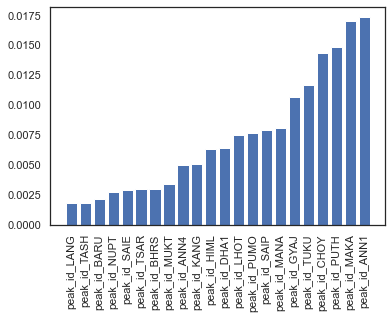

In [350]:
# feature importance
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
dfeat = dfeat[dfeat['feature'].str.contains('peak_id')]
dfeat = dfeat.sort_values(by='value')

val = 0
# plot
plt.bar(dfeat.loc[dfeat['value']> val , 'feature'], dfeat.loc[dfeat['value']> val , 'value'])
plt.xticks(rotation=90)
plt.show()

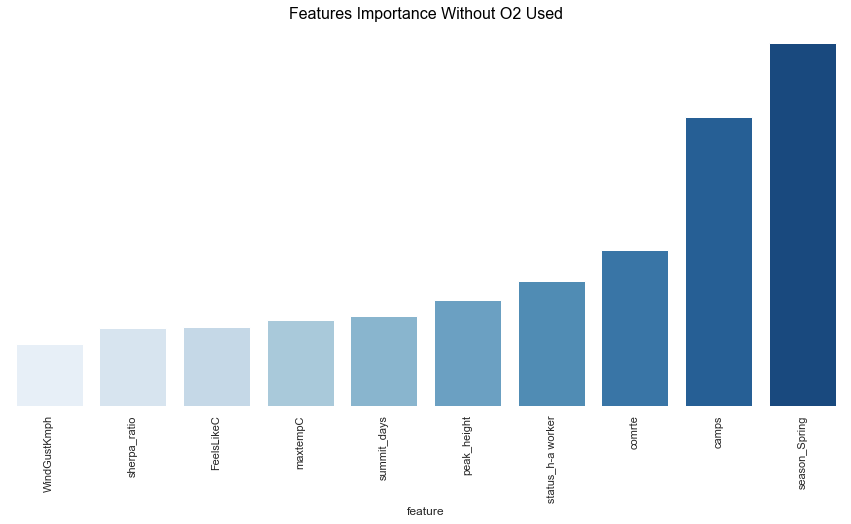

In [372]:
# feature without peak_id
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
df_feat_2 = dfeat[~dfeat['feature'].str.contains('peak_id')]
df_feat_2 = df_feat_2.sort_values(by='value')

palette = sns.color_palette("Blues_r", n_colors=10)
palette.reverse()

plt.figure(figsize=(15,7))
sns.barplot(x=df_feat_2.tail(10)['feature'], y=df_feat_2.tail(10)['value'], palette=palette)
plt.xticks(rotation=90)
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True, left=True)
plt.yticks([])
plt.ylabel('')
plt.title('Features Importance Without O2 Used', fontdict = font)
plt.show()

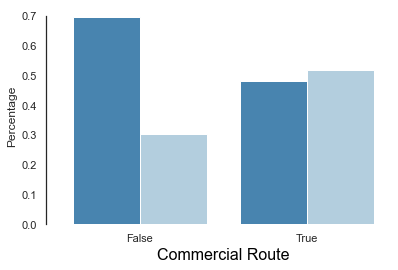

In [373]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16}

x, y, hue = "comrte", "Percentage", "summit_success"
prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

splot = sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Commercial Route', fontdict=font)
plt.show()

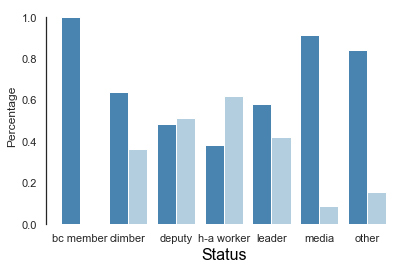

In [374]:
x, y, hue = "status", "Percentage", "summit_success"
prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

splot = sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Status', fontdict=font)
plt.show()

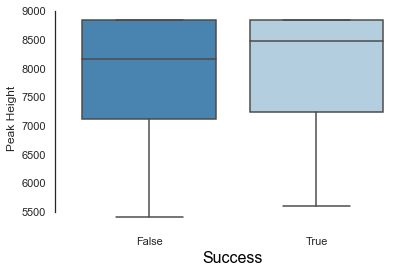

In [375]:
sns.boxplot(y=df["peak_height"],x=df['summit_success'], palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Peak Height')
plt.show()

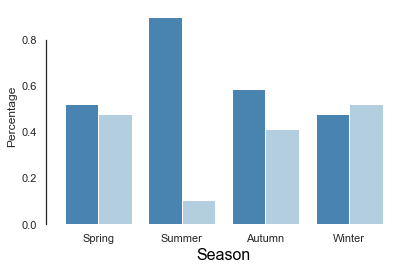

In [376]:
x, y, hue = "season", "Percentage", "summit_success"

prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

field = "season"
day_order = ["Spring", "Summer", "Autumn", "Winter"]
prop_df = prop_df.set_index(field).loc[day_order]

sns.barplot(x=prop_df.index, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Season', fontdict=font)
plt.legend().remove()
plt.show()

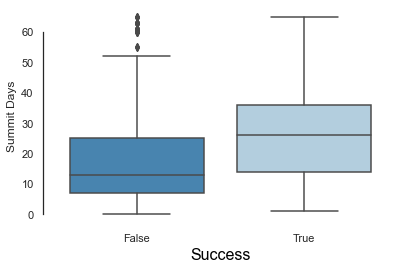

In [298]:
sns.boxplot(y=df["summit_days"],x=df['summit_success'], palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Summit Days')
plt.show()

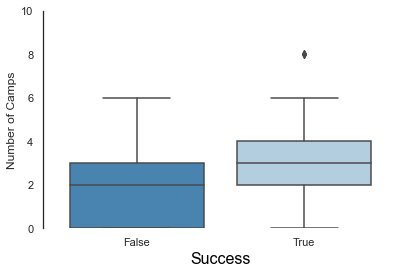

In [377]:
sns.boxplot(y=df["camps"],x=df['summit_success'], palette="Blues_r")
plt.ylim((0,10))
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Number of Camps')
plt.show()

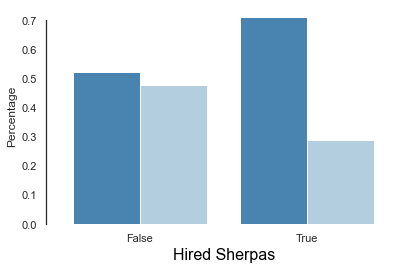

In [378]:
x, y, hue = "no_hired", "Percentage", "summit_success"

prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Hired Sherpas', fontdict=font)
plt.show()

### Feature permutation

In [195]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(boost, X_test, y_test)

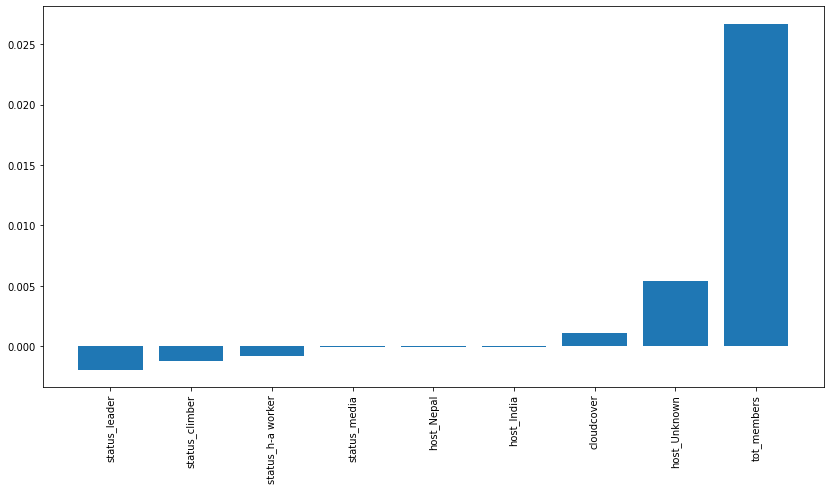

In [196]:
sorted_idx = perm_importance.importances_mean.argsort()

Y = list(sorted_idx)
sorted_feat = [x for _,x in sorted(zip(Y,feature_names))]

dfeat_prem = pd.DataFrame(data=perm_importance.importances_mean[sorted_idx])
dfeat_prem['feature'] = sorted_feat
dfeat_prem.columns = ['value', 'feature']
dfeat_prem = dfeat_prem.sort_values(by='value')
dfeat_prem = dfeat_prem[~dfeat_prem['feature'].str.contains('peak')]
dfeat_prem = dfeat_prem[dfeat_prem['value']!=0]


val = 0.005
# plot
plt.bar(dfeat_prem.feature, dfeat_prem.value)
plt.xticks(rotation=90)
plt.show()

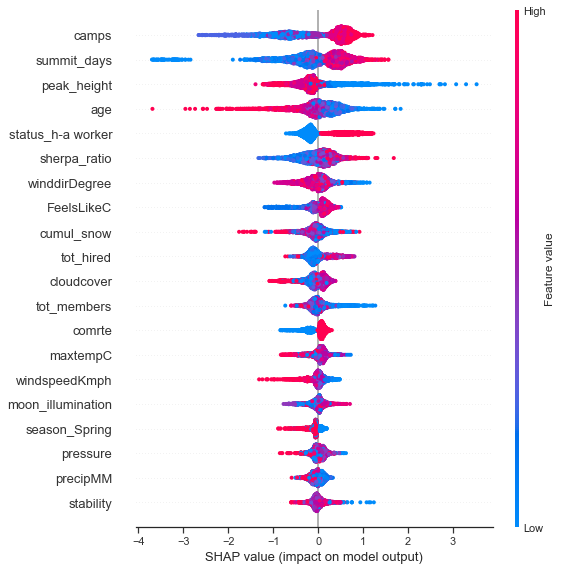

In [393]:
import shap
explainer = shap.TreeExplainer(boost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names= feature_names)

## Other Models

In [379]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter=500)
reg.fit(X_train, y_train)
ypred = reg.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.73      0.75      0.74      2290
        True       0.68      0.65      0.67      1852

    accuracy                           0.71      4142
   macro avg       0.71      0.70      0.70      4142
weighted avg       0.71      0.71      0.71      4142



In [380]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.83      0.81      0.82      2290
        True       0.77      0.80      0.78      1852

    accuracy                           0.80      4142
   macro avg       0.80      0.80      0.80      4142
weighted avg       0.80      0.80      0.80      4142



In [384]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1


def initialize_model():
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(176,)))
    model.add(layers.Dense(200, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(100, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    # Model optimization : Optimizer, loss and metric 
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 30, restore_best_weights=True)

model_NN = initialize_model()

history = model_NN.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs= 300, 
                    batch_size=8,
                    verbose=0,
                   callbacks = [es])

y_pred_NN = model_NN.predict_classes(X_test)
print(classification_report(y_test, y_pred_NN))

              precision    recall  f1-score   support

       False       0.83      0.75      0.79      2290
        True       0.73      0.81      0.77      1852

    accuracy                           0.78      4142
   macro avg       0.78      0.78      0.78      4142
weighted avg       0.78      0.78      0.78      4142



## RandomSearchCV

### XGB

In [389]:
%%time
from sklearn.model_selection import RandomizedSearchCV

params = {'booster' : ['gbtree', 'gblinear'],
        'min_child_weight': [0.1, 1, 5, 10, 50],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10, 25, 50],
        'learning_rate': [0.0001, 0.001, 0.1, 1],
        'n_estimators': [50, 100, 250, 500],
        'reg_alpha': [0.0001, 0.001, 0.1, 1],
        'reg_lambda': [0.0001, 0.001, 0.1, 1]
        }

model = XGBClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


Wall time: 2min 1s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                             

In [199]:
boost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [390]:
best_model = random_search.best_estimator_
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.0001, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [391]:
y_xgbCV = best_model.predict(X_test)
print(classification_report(y_test, y_xgbCV))

              precision    recall  f1-score   support

       False       0.86      0.80      0.83      2290
        True       0.77      0.84      0.80      1852

    accuracy                           0.82      4142
   macro avg       0.82      0.82      0.82      4142
weighted avg       0.82      0.82      0.82      4142



In [392]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.81      0.83      2290
        True       0.78      0.83      0.80      1852

    accuracy                           0.82      4142
   macro avg       0.81      0.82      0.81      4142
weighted avg       0.82      0.82      0.82      4142



### RFC

In [385]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators' : [100,200,500],
        'criterion' : ['gini', 'entropy'],
        'min_samples_split': [2, 3, 5],
        'max_depth': [5, 10, 25, 50],
        'min_samples_leaf': [1, 3, 5],
        'max_features': ["sqrt", "log2"]
        }

model = RandomForestClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.8s finished


Wall time: 28.9 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 25, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [100, 200, 500]},
                   random_state=1001, scoring='accuracy', verbose=1)

In [386]:
best_RFC = random_search.best_estimator_

In [387]:
best_RFC

RandomForestClassifier(criterion='entropy', max_depth=25, max_features='log2',
                       min_samples_split=5, n_estimators=200)

In [388]:
ypred = best_RFC.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.81      0.83      2290
        True       0.78      0.83      0.80      1852

    accuracy                           0.82      4142
   macro avg       0.81      0.82      0.81      4142
weighted avg       0.82      0.82      0.82      4142



# Test xgb_model.py

In [1]:
from xgb_model import HimalXGB

model = HimalXGB().train_model()

In [2]:
model2 = HimalXGB().load_model()
model2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
yhat = HimalXGB().predict_model(X)
yhat

['rope', 'no_hired', 'comrte', 'stdrte', 'o2_used']


array([ True, False,  True, ...,  True, False,  True])

# Model without weather

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_bid','summit_term','summit_date1',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])
exped['rope'] = np.where(exped['rope']>0, True, False)



# Merge DataFrames
df = exped.merge(member, on='exp_id', how = 'right')


feature_to_drop = ['primrte', 'disabled', 
                   'traverse', 'parapente', 'solo', 'ski', 'speed', 
                   'summit_date', 'exp_id', 'bc_date', 'term_reason']

df.drop(columns= feature_to_drop, inplace=True)

In [211]:
# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

bool_transformer = Pipeline(steps=[
    ('imputer', BoolImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('bool', bool_transformer, col_bool),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [214]:
ohe_col = list(clf.named_steps['preprocessor'].transformers_[2][1]\
   .named_steps['onehot'].get_feature_names(col_object))

feature_names = col_num + col_bool + ohe_col

In [212]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.87      0.87      0.87      2792
        True       0.83      0.83      0.83      2123

    accuracy                           0.85      4915
   macro avg       0.85      0.85      0.85      4915
weighted avg       0.85      0.85      0.85      4915



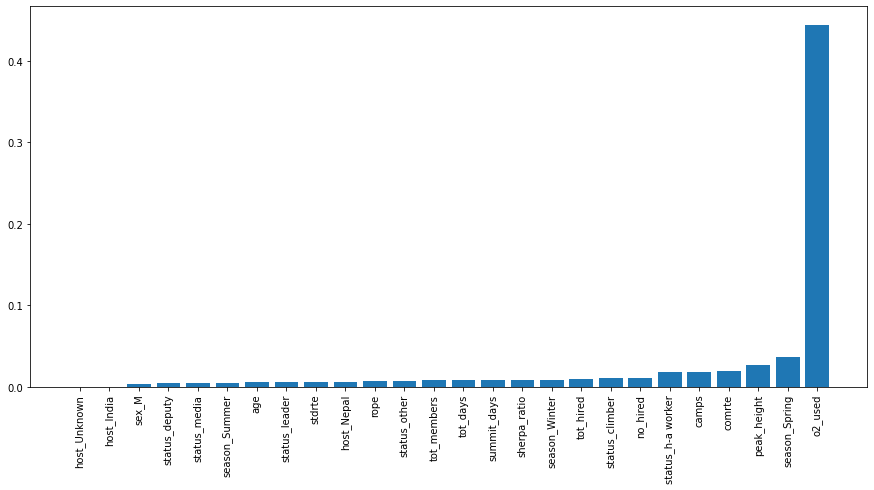

In [215]:
# feature without peak_id
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
df_feat_2 = dfeat[~dfeat['feature'].str.contains('peak_id')]
df_feat_2 = df_feat_2.sort_values(by='value')

# plot
plt.figure(figsize=(15,7))
plt.bar(df_feat_2.feature, df_feat_2.value)
plt.xticks(rotation=90)
plt.show()

# Peaks GPS

In [66]:
import pandas as pd

#gps = pd.read_excel('data/Peaks_GPS.xls')

gps = pd.read_excel('data/main_peaks.xlsx')

In [68]:
import re

def coord(x):
    numbers = re.findall(r'\d+', x)
    unit = int(numbers[0])
    dec = int(numbers[1])/60
    cent = int(numbers[2])/3600
    
    return round(unit+dec+cent,4)

In [70]:
gps['lat'] = gps['lat'].apply(lambda x: coord(x))
gps['lon'] = gps['lon'].apply(lambda x: coord(x))

In [74]:
import folium

m = folium.Map(
    location=[27.98, 86.92],
    zoom_start=8,
    tiles='Stamen Terrain'
)

feature_group = folium.FeatureGroup("Locations")
for lat, lng, name in zip(gps.lat, gps.lon, gps.peak_name):
    feature_group.add_child(folium.Marker(location=[lat,lng], popup=name))

m.add_child(feature_group)

folium.Marker(
    location=[27.948056, 86.810278],
    popup='Weather Station',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)


m

# Dash

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from data import Data

app = dash.Dash(__name__)

# ------------------------------------------------------------------------------
# Import and clean data (importing csv into pandas)
df = Data().get_matching_table()

mylist = df.peak_id.unique()
peak_list = pd.DataFrame({'peak' : mylist})

# ------------------------------------------------------------------------------
# App layout
app.layout = html.Div([

    html.H1("HimalayApp", style={'text-align': 'center'}),

    dcc.RangeSlider(
        id='year_slider',
        min=2010,
        max=2020,
        step=1,
        value=[2010, 2020],
        marks= {i : str(i) for i in range(2010, 2021)}),

    html.Div(id='output_container', children=[]),
    html.Br(),

    dcc.Dropdown(
        id='dropdown',
        options=[{'label':i, 'value':i} for i in peak_list['peak']]),

    html.Div(id='output', children=[]),
    html.Br(),

    html.Div(html.Iframe(src = "https://fatmap.com/around/Mount_Everest/China/@27.9967433,86.9117653,28274.0557688,-63.6300764,0.4395348,7406.1808273,normal"))
])


# # ------------------------------------------------------------------------------
# # Connect the Plotly graphs with Dash Components
# @app.callback(
#     [Output(component_id='output_container', component_property='children'),
#      Output(component_id='output', component_property='children')],
#     [Input(component_id='year_slider', component_property='value')])



# # ------------------------------------------------------------------------------
__name__ == '__main__'
app.run_server(debug=True)

KeyboardInterrupt: 

In [ ]:
url = "https://fatmap.com/routeid/339173/camp-one-to-camp-two-and-three?fmid=em"
app.layout = html.Div([
    html.Embed(src=url,width="750",height="400"),
    html.Div(id='my-div')
])


@app.callback(
    Output(component_id='my-div', component_property='children')
)

app.run_server("inline",port=8060)

# PCA & Tsne

In [19]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_train)

Wall time: 173 ms


In [5]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.23019437 0.13375674 0.09745844 0.07005311]


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = 2
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(0.06504242909265336, -0.23598855923214312, '0'),
  Text(-0.36790246038906493, 0.21029167619471711, '1')])

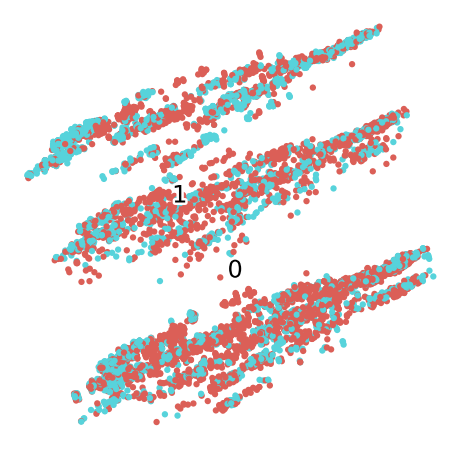

In [29]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,y_train) # Visualizing the PCA output

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(0.74906886, -5.88719, '0'), Text(0.2669046, 6.683646, '1')])

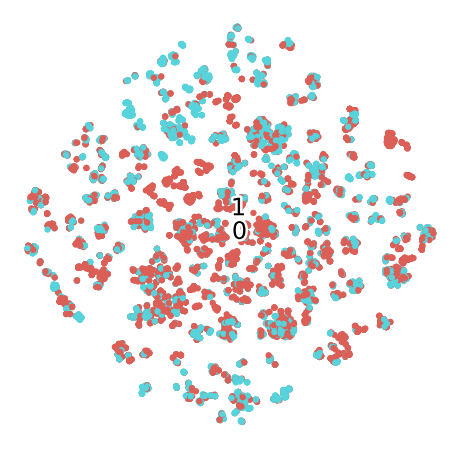

In [16]:
# PCA 50

pca_50 = PCA(n_components=30)
pca_result_50 = pca_50.fit_transform(X_train)
fashion_pca_tsne = TSNE(random_state=21).fit_transform(pca_result_50)
fashion_scatter(fashion_pca_tsne, y_train)

In [38]:
from sklearn.manifold import TSNE
import plotly.express as px

features = X_train

tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(features, )

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_train, labels={'color': 'Success'}
)
fig.update_traces(marker_size=8)
fig.show()